# Toy model (updated fidelity)

Can also run `toy_immunity_demo.py` (same code, just in script form, not notebook form). 

\begin{align*}
\frac{dS}{dt} &= \sigma^{R\rightarrow S} R(t) - \frac{\beta I(t)}{N} \frac{S(t)}{(1 + k^I M(t) + k^I_v M_v(t))} \\
\frac{dI}{dt} &= \frac{\beta I(t)}{N} \frac{S(t)}{(1 + k^I M(t) + k^I_v M_v(t))} - \gamma^{I\rightarrow H} \tilde{\pi}^{I \rightarrow H} \frac{I(t)}{(1 + k^H M(t) + k^H_v M_v(t))} - \gamma^{I \rightarrow R} (1 - \tilde{\pi}^{I \rightarrow H}) I(t) \\
\frac{dH}{dt} &= \gamma^{I\rightarrow H} \tilde{\pi}^{I \rightarrow H} \frac{I(t)}{(1 + k^H M(t) + k^H_v M_v(t))} - \gamma^{H \rightarrow R} H(t) \\
\frac{dR}{dt} &= \gamma^{I \rightarrow R} I(t) + \gamma^{H \rightarrow R} H(t) - \sigma^{R\rightarrow S} R(t) \\
\frac{dM}{dt} &= \frac{\sigma^{R \rightarrow S} R(t)}{N(1 + o M(t) + o_v M_v(t))} - w M(t) \\
\frac{dM_v}{dt} &= \frac{V(t - \delta)}{N} - w_v M_v(t) \\
\end{align*}

where

- $N$: total number of people
- $\beta$: transmission rate (people per day)
- $\sigma^{R \rightarrow S}$:  rate at which people move from $R$ to $S$ (people per day) 
- $\gamma^{I \rightarrow R}$:  rate at which people move from $I$ to $R$ (people per day)
- $\gamma^{H \rightarrow R}$:  rate at which people move from $H$ to $R$ (people per day)
- $\tilde{\pi}^{I \rightarrow H}$: rate-adjusted proportion of infected individuals who get hospitalized
- $k^I$, $k^I_v$: "infection risk reduction" constants for $M$ and $M_v$ respectively
- $k^H$, $k^H_v$: "hospitalization risk reduction" constants for $M$ and $M_v$ respectively
- $w$, $w_v$: infection-induced immunity waning rate and vaccine-induced immunity waning rate respectively (derived from half-life of immunity antibodies -- antibodies per day?)
- $o$, $o_v$: immune saturation constants for $M$ and $M_v$ respectively -- used to create saturation or diminishing returns effect of additional infections (again, units/interpretation still unknown/unclear) -- we will get these values from Anass
- $V(t)$ is the number of people vaccinated on day $t$, and $\delta$ is the number of days it takes for the vaccine to be effective


# Important notes

- Remy notes that for the $dI/dt$ equation, the other appearance of $I(t)$ in the $I$ to $R$ transition should also be scaled by $1/(1 + k^H M(t) + k^H_v M_v(t))$ -- otherwise total outgoing flow from $I$ will not be correct -- this makes sense to me, but I am curious about what others think about it -- documenting this for discussion
- Currently in this toy model code, we have $V(t)$ constant (see parameter `vaccines_per_day` in `params` dict)

In [12]:
# Parameter variable names and default values

from pathlib import Path
base_path = Path().parent / "toy_immunity_input_files"
config_filepath = base_path / "config.json"
params_dict = clt.load_json_new_dict(params_filepath)

for key, value in params_dict.items():
    print(key, value)

num_age_groups 1
num_risk_groups 1
total_pop 100000
beta 1.5
I_to_H_rate 0.5
I_to_R_rate 0.25
H_to_R_rate 0.1
R_to_S_rate 0.02
I_to_H_adjusted_prop 0.1
inf_induced_saturation 100
inf_induced_immune_wane 0.0002
vax_induced_saturation 10
vax_induced_immune_wane 0.004
inf_induced_inf_risk_constant 4
inf_induced_hosp_risk_constant 4
vax_induced_inf_risk_constant 1.5
vax_induced_hosp_risk_constant 1.5
vaccines_per_day 100


In [ ]:
# Simple demo with flu model with "toy" (not fitted or realistic) parameters

###########################################################
######################## IMPORTS ##########################
###########################################################

import numpy as np
import pandas as pd

import toy_immunity_plotting

import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))

# Import city-level transmission base components module
import clt_base as clt

# Import flu model module, which contains customized subclasses
import toy_immunity_components as imm

###########################################################
################# READ INPUT FILES ########################
###########################################################

# Obtain path to folder with JSON input files
base_path = Path().parent / "toy_immunity_input_files"

# Get filepaths for initial values of compartments and epi metrics, fixed parameters,
#   configuration, and travel proportions
compartments_epi_metrics_init_vals_filepath = base_path / "compartments_epi_metrics_init_vals.json"
params_filepath = base_path / "params.json"
config_filepath = base_path / "config.json"

# Read in files as dictionaries and dataframes
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file
compartments_epi_metrics_dict = \
    clt.load_json_new_dict(compartments_epi_metrics_init_vals_filepath)
params_dict = clt.load_json_new_dict(params_filepath)
config_dict = clt.load_json_new_dict(config_filepath)

# Create two independent bit generators
bit_generator = np.random.MT19937(88888)
jumped_bit_generator = bit_generator.jumped(1)

###########################################################
############# CREATE SUBPOPULATION MODELS #################
###########################################################

# Create two subpopulation models, one for the north
#   side of the city and one for the south side of the city
# In this case, these two (toy) subpopulations have the
#   same demographics, initial compartment and epi metric values,
#   fixed parameters, and school-work calendar.
# If we wanted the "north" subpopulation and "south"
#   subpopulation to have different aforementioned values,
#   we could read in two separate sets of files -- one
#   for each subpopulation
model = imm.ToyImmunitySubpopModel(compartments_epi_metrics_dict,
                                   params_dict,
                                   config_dict,
                                   np.random.Generator(bit_generator))

model.simulate_until_day(300)

model2 = imm.ToyImmunitySubpopModel(compartments_epi_metrics_dict,
                                   params_dict,
                                   config_dict,
                                   np.random.Generator(bit_generator))

model2.params.beta = 3

model2.simulate_until_day(300)

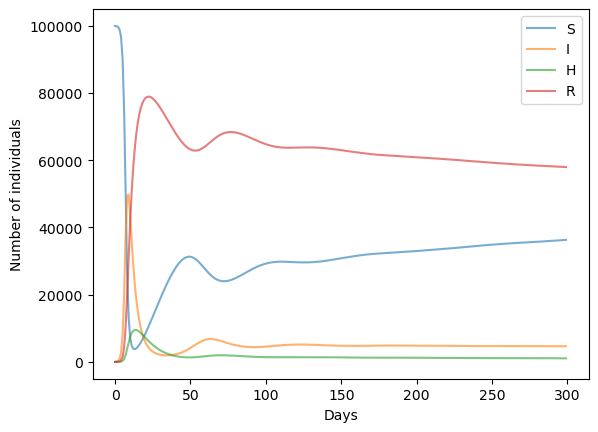

In [2]:
clt.plot_subpop_basic_compartment_history(model)

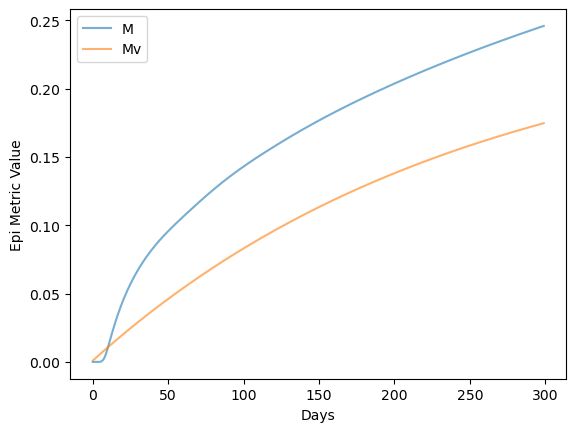

In [3]:
clt.plot_subpop_epi_metrics(model)

<Figure size 640x480 with 0 Axes>

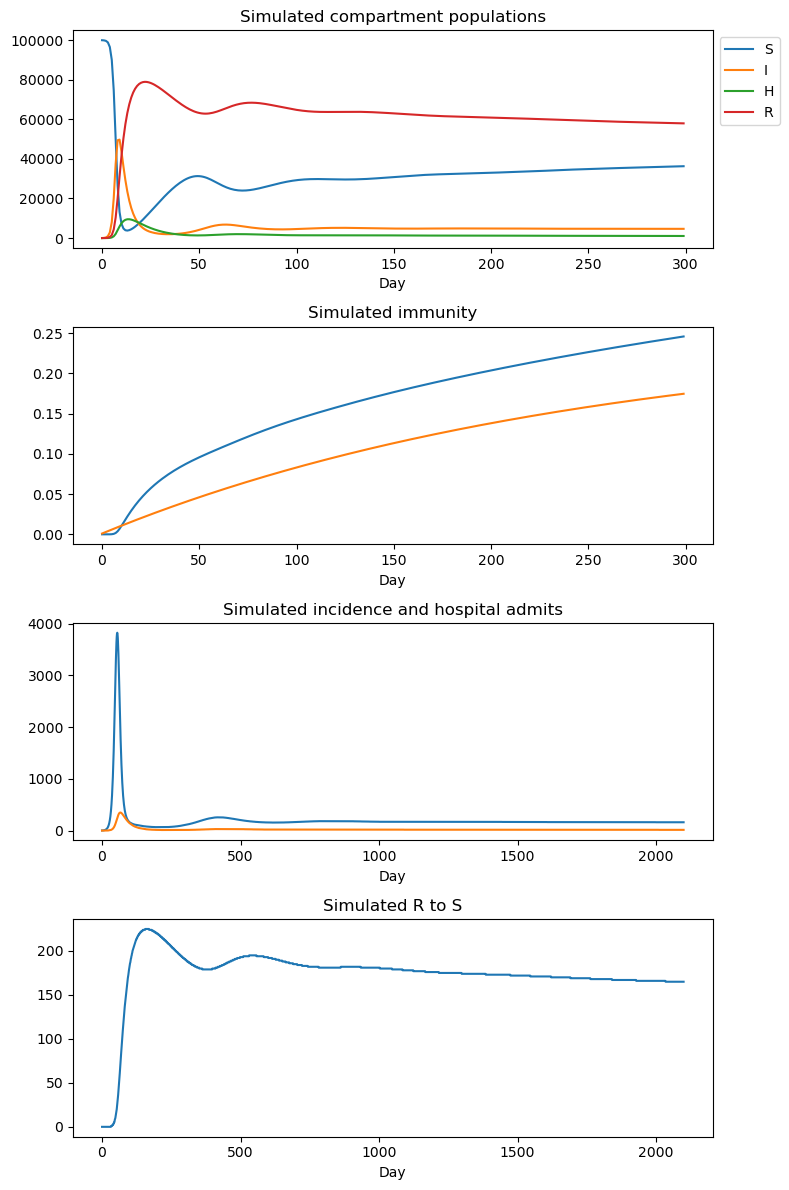

In [4]:
toy_immunity_plotting.make_graph_set(model)

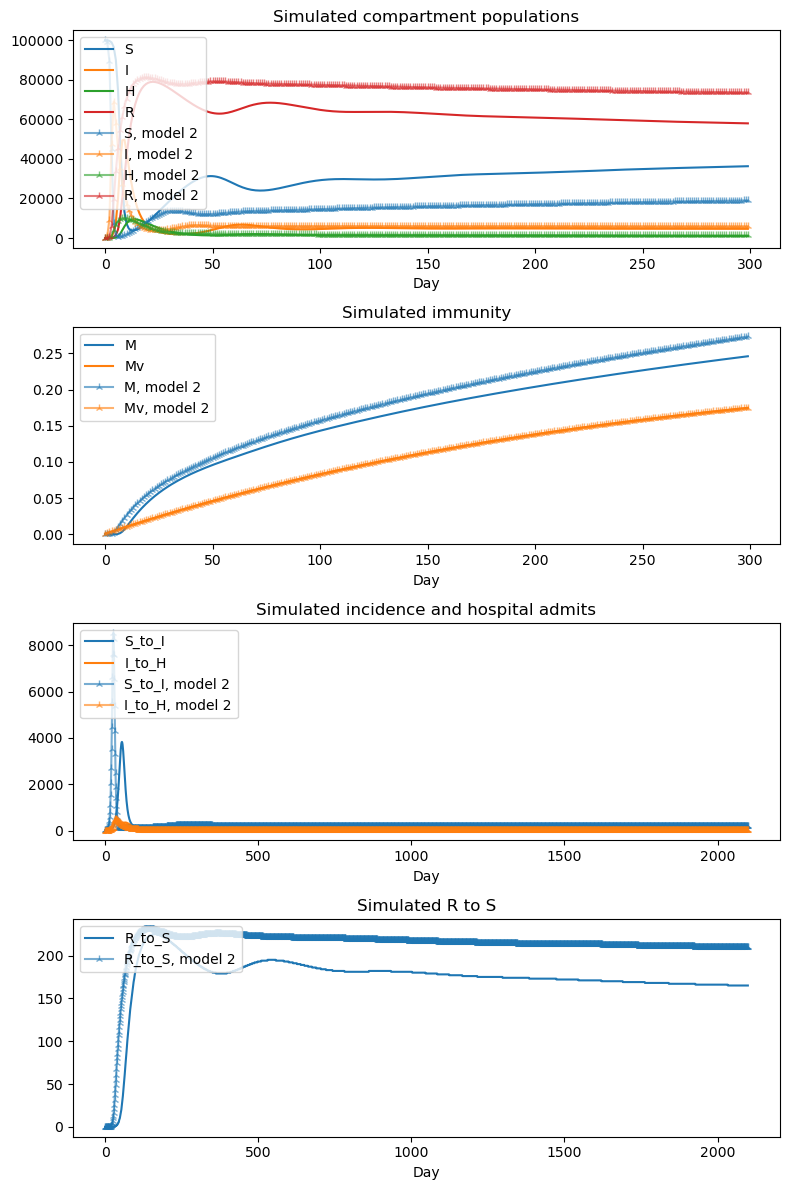

In [5]:
toy_immunity_plotting.make_comparison_graph_set(model, model2)

<Figure size 640x480 with 0 Axes>

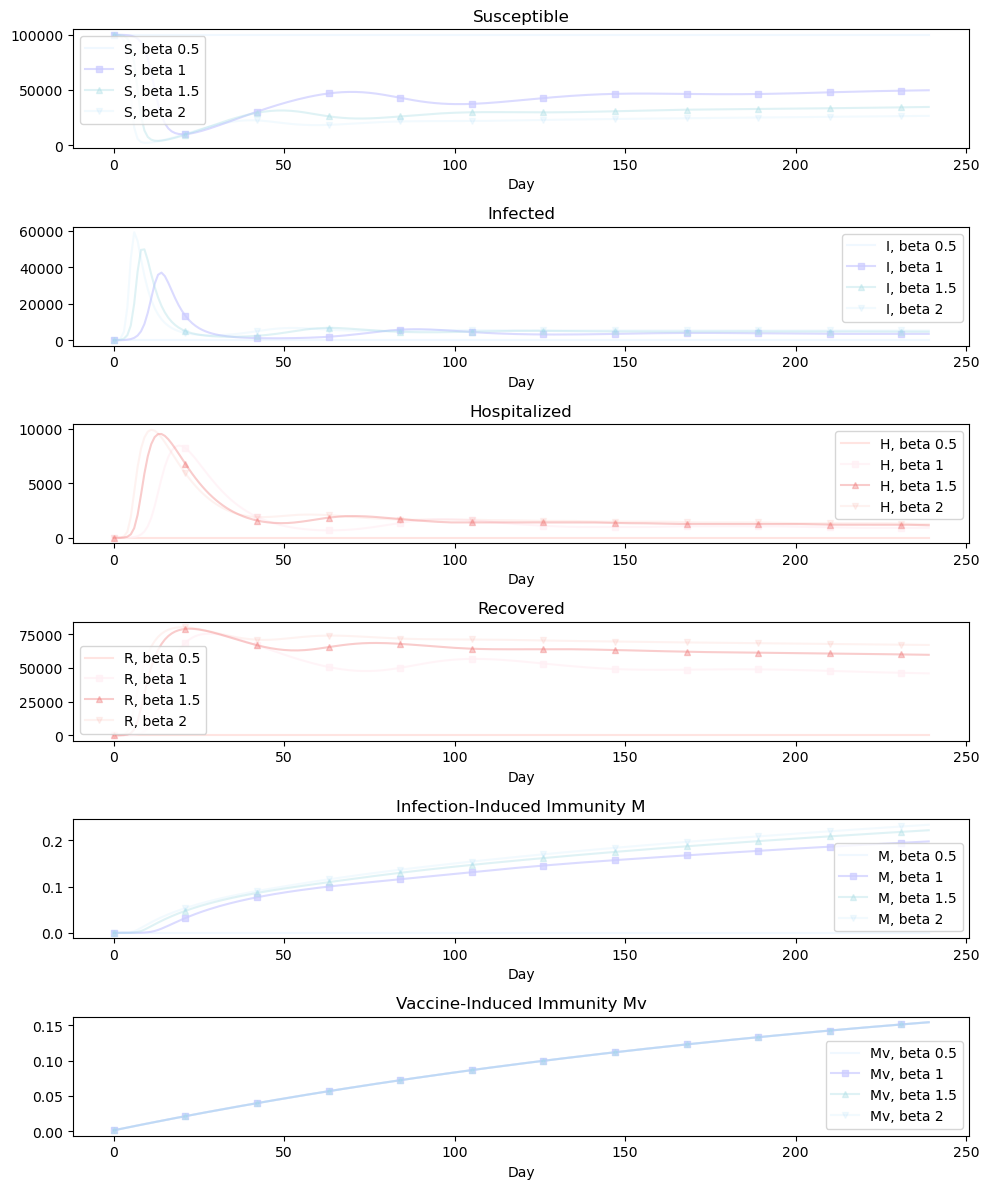

In [6]:
toy_immunity_plotting.changing_param_val_graph(model, "param", "beta", [0.5, 1, 1.5, 2])